In [1]:
import simpy, random, logging
from queue_simulation_mod import (
    ServiceOperation, SIMULATION_DURATION, SEED,
    SocialWorkerShifts, DutyOfficerShifts, VolunteerShifts)

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools

In [2]:
sns.set();

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('paper', font_scale=1.5)

In [4]:
folder = 'img' # image folder
interarrivals_file = 'interarrivals_day_of_week_hour/Oct2020_to_Nov2020/interarrivals_day_of_week_hour.csv'

# 1. plot counsellor shifts

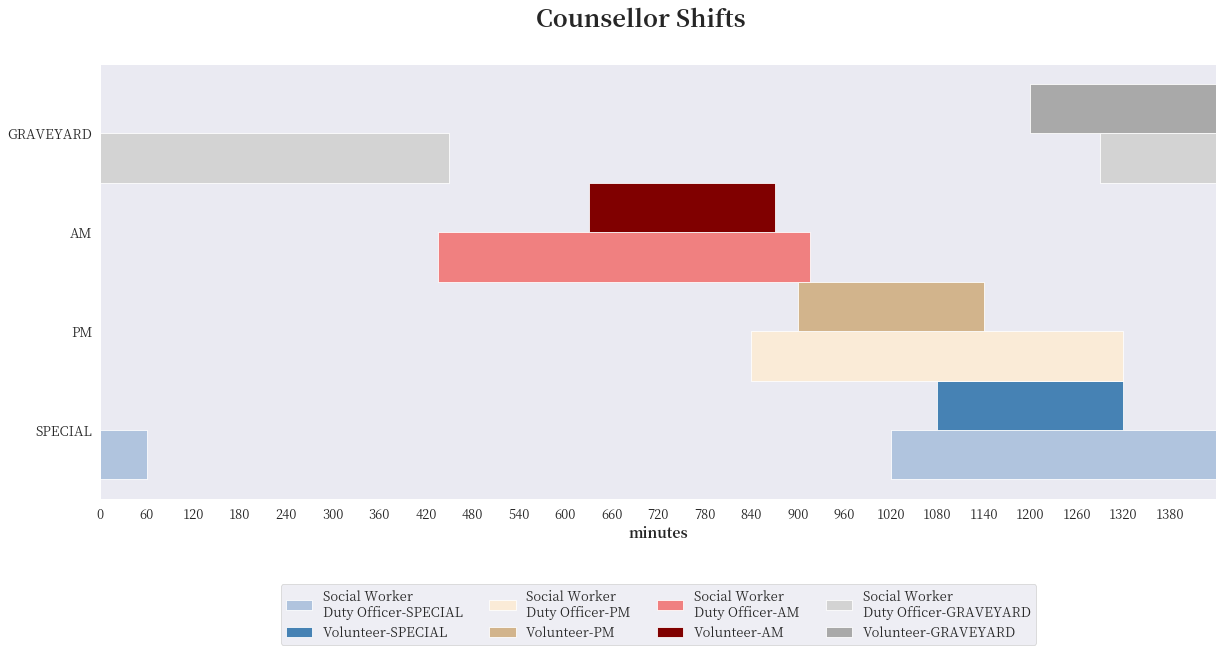

In [5]:
fig, ax = plt.subplots( figsize=(20, 8))
ax.set_xlim(0, 1440)


# special
ax.broken_barh([(SocialWorkerShifts.SPECIAL.start, 1440),
    (0, SocialWorkerShifts.SPECIAL.end%1440)],
    (1, 1), facecolors='lightsteelblue',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.SPECIAL.shift_name}')
ax.broken_barh([(VolunteerShifts.SPECIAL.start,
    VolunteerShifts.PM.duration)],
    (2, 1), facecolors='steelblue',
    label=f'Volunteer-{VolunteerShifts.SPECIAL.shift_name}')


# PM
ax.broken_barh([(SocialWorkerShifts.PM.start,
    SocialWorkerShifts.PM.duration)],
    (3, 1), facecolors='antiquewhite',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.PM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.PM.start,
    VolunteerShifts.PM.duration)],
    (4, 1), facecolors='tan',
    label=f'Volunteer-{VolunteerShifts.PM.shift_name}'
)



# AM
ax.broken_barh([(SocialWorkerShifts.AM.start, 
    SocialWorkerShifts.AM.duration)],
    (5, 1), facecolors='lightcoral',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.AM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.AM.start, 
    VolunteerShifts.AM.duration)],
    (6, 1), facecolors='maroon',
    label=f'Volunteer-{VolunteerShifts.AM.shift_name}'
)


# graveyard
ax.broken_barh([(SocialWorkerShifts.GRAVEYARD.start, 1440),
    (0, SocialWorkerShifts.GRAVEYARD.end%1440)],
    (7, 1), facecolors='lightgrey',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.GRAVEYARD.shift_name}'              
)
ax.broken_barh([(VolunteerShifts.GRAVEYARD.start,
    VolunteerShifts.GRAVEYARD.end)],
    (8, 1), facecolors='darkgrey',
    label=f'Volunteer-{VolunteerShifts.GRAVEYARD.shift_name}',
)


ax.set_xticks([x for x in range(0, 1440, 60)])
ax.set_xlabel('minutes')
ax.set_yticks([x for x in range(2, 9 , 2)])
ax.set_yticklabels([
    SocialWorkerShifts.GRAVEYARD.shift_name,
    SocialWorkerShifts.AM.shift_name,
    SocialWorkerShifts.PM.shift_name,
    SocialWorkerShifts.SPECIAL.shift_name,
    ][::-1])

fig.suptitle('Counsellor Shifts', fontweight='bold', fontsize=24)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=4)

fig.savefig(f'{folder}/shifts.png', dpi=300, bbox_inches='tight')

plt.show()

# 2. Queue Simulation (multi-process to speed up bootstrap)

In [6]:
import multiprocessing as mp
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [7]:
manager = mp.Manager()

In [8]:
queue_status = manager.list()
max_queue_length = manager.list()
num_users = manager.list()
num_users_accepted_TOS = manager.list()
num_users_rejected_TOS = manager.list()
num_users_served = manager.list()
num_users_served_g_regular = manager.list()
num_users_served_g_repeated = manager.list()
num_users_served_g_valid = manager.list()
num_users_reneged = manager.list()
# num_users_reneged_g_regular = manager.list()
# num_users_reneged_g_repeated = manager.list()
num_available_counsellor_processes = manager.list()
queue_time_stats = manager.list()
renege_time_stats = manager.list()
case_chat_time = manager.list()

In [9]:
# comment out line if not reproducing results
random.seed(728)

# seed for thinning algorithm
thinning_random = random.Random()
thinning_random.seed(305)

num_iterations = 1500 # this should be multiples of num_cores
num_cores = max(mp.cpu_count()-2, 2)

In [10]:
# load time series of interarrivals (specified in SECONDS)
df = pd.read_csv(interarrivals_file, index_col=0)

# otherwise
boxcox_lambda = .5 # transformation is sqrt(y)
ts_period = 12
num_harmonics = 3

transformed_data = boxcox(1/df['y'], boxcox_lambda)


ucm = UnobservedComponents(
    transformed_data,
    level='fixed intercept',
    freq_seasonal=[
        {'period': ts_period,'harmonics': num_harmonics},
    ],
    autoregressive=1,
)
fitted_ts = ucm.fit(disp=False)

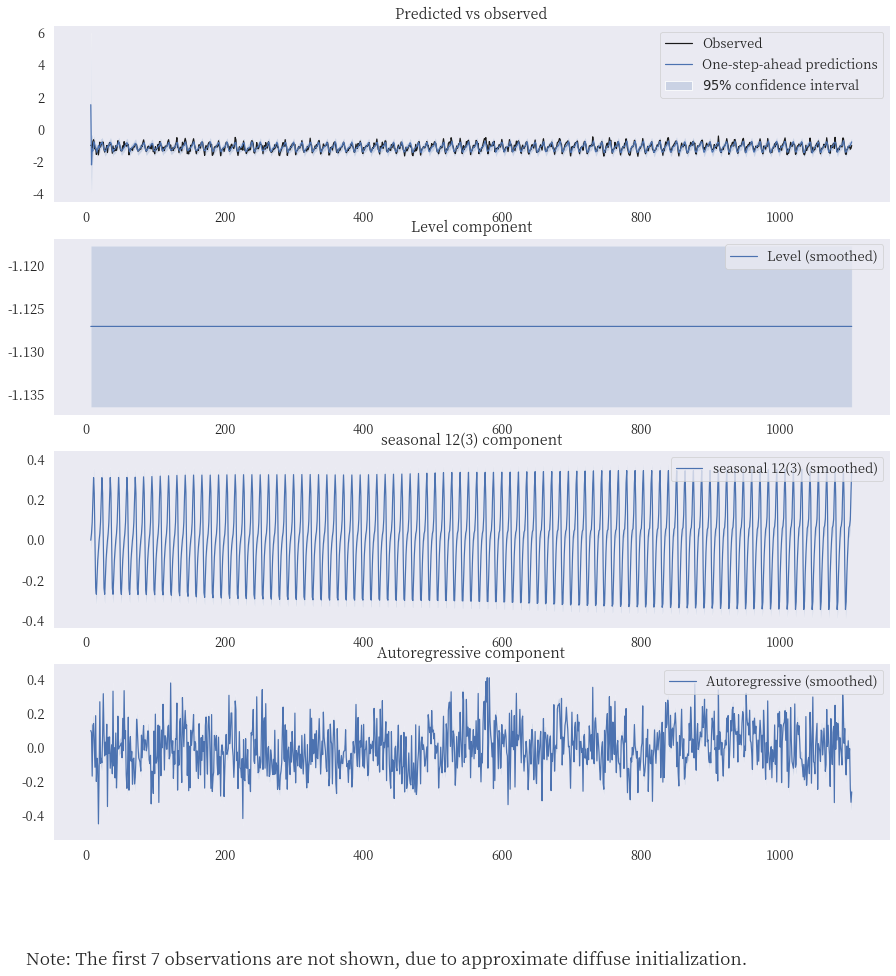

In [11]:
fitted_ts.plot_components(figsize=(15, 15))
plt.show()

In [12]:
def run_simulation(
        queue_status,
        max_queue_length,
        num_users,
        num_users_accepted_TOS,
        num_users_rejected_TOS,
        num_users_served,
        num_users_served_g_regular,
        num_users_served_g_repeated,
        num_users_served_g_valid,
        num_users_reneged,
        num_available_counsellor_processes,
        queue_time_stats,
        renege_time_stats,
        case_chat_time):

    for i in tqdm(
        range(num_iterations//num_cores), 
        desc='OpenUp Queue Simulation'):

        try:
            # create environment
            env = simpy.Environment() 

            # set up service operation and run simulation until  
            S = ServiceOperation(
                env=env,
                ts=fitted_ts,
                ts_period=ts_period,
                thinning_random=thinning_random,
                boxcox_lambda=boxcox_lambda,
                use_actual_interarrivals=True
            )
            env.run(until=SIMULATION_DURATION)


            num_users.append(S.num_users)   
            num_users_accepted_TOS.append(S.num_users_TOS_accepted)
            num_users_rejected_TOS.append(S.num_users_TOS_rejected)
            max_queue_length.append(S.user_queue_max_length)
            
            queue_status.append(pd.DataFrame(S.queue_status) )
            num_available_counsellor_processes.append(
                pd.DataFrame(S.num_available_counsellor_processes,
                             columns=['time', 'num_counsellor_processes_idle'])
            )
            
            num_users_served.append(S.served)
            num_users_served_g_regular.append(S.served_g_regular)
            num_users_served_g_repeated.append(S.served_g_repeated)
            num_users_served_g_valid.append(S.served_g_valid)
            num_users_reneged.append(S.reneged)
            
            queue_time_stats.append(pd.DataFrame(S.queue_time_stats) )
            renege_time_stats.append(pd.DataFrame(S.renege_time_stats) )
            case_chat_time.append(pd.DataFrame(S.case_chat_time,
                                            columns=['cumulative_chat_time']) )
            
        #     num_users_reneged_g_regular.append(S.reneged_g_regular)
        #     num_users_reneged_g_repeated.append(S.reneged_g_repeated)
        except ValueError:
            print(f'Negative delay at {i}.  Results are dropped.')

## divide up jobs to `num_cores`, and merge results when complete

In [13]:
jobs = [mp.Process(target=run_simulation, args=[
            queue_status,
            max_queue_length,
            num_users,
            num_users_accepted_TOS,
            num_users_rejected_TOS,
            num_users_served,
            num_users_served_g_regular,
            num_users_served_g_repeated,
            num_users_served_g_valid,
            num_users_reneged,
            num_available_counsellor_processes,
            queue_time_stats,
            renege_time_stats,
            case_chat_time
        ]) for i in range(num_cores)]        
    
for j in jobs:
    j.start()
    
    
for j in jobs:
    j.join()

OpenUp Queue Simulation: 100%|██████████| 250/250 [06:15<00:00,  1.50s/it]


## convert to pandas objects

In [14]:
num_users = pd.Series(np.array(num_users), name='number of users')
num_users_accepted_TOS = pd.Series(np.array(num_users_accepted_TOS), name='number of users accepting TOS')
num_users_rejected_TOS = pd.Series(np.array(num_users_rejected_TOS), name='number of users rejecting TOS')
num_users_served = pd.Series(np.array(num_users_served), name='number of users served')
num_users_served_g_regular = pd.Series(np.array(num_users_served_g_regular), name='number of users served')
num_users_served_g_repeated = pd.Series(np.array(num_users_served_g_repeated), name='number of repeated users served')
num_users_served_g_valid = pd.Series(np.array(num_users_served_g_valid), name='number of cases passing valid threshold')
num_users_reneged = pd.Series(np.array(num_users_reneged), name='number of users reneged')
# num_users_reneged_g_regular = pd.Series(num_users_reneged_g_regular, name='number of users reneged')
# num_users_reneged_g_repeated = pd.Series(num_users_reneged_g_repeated, name='number of repeated users reneged')
queue_status = pd.concat(queue_status)
max_queue_length = pd.Series(np.array(max_queue_length), name='max queue length')
queue_time_stats = pd.concat(queue_time_stats)
renege_time_stats = pd.concat(renege_time_stats)
num_available_counsellor_processes = pd.concat(num_available_counsellor_processes)
case_chat_time = pd.concat(case_chat_time)

In [15]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None, verbose=True):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
    
    if verbose:
        print('\n%s %d%% Confidence interval:' % (
            metadata, confidence_interval) )
        print('----------------------------')
        print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
        print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
        print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [16]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{folder}/{filename}.png', dpi=300, bbox_inches='tight')

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


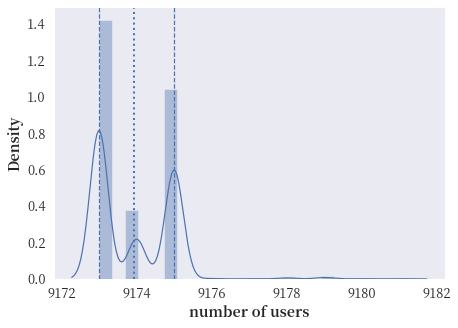

In [17]:
plot_distribution(num_users, 'num_users')

In [18]:
lower, upper, mean = calculate_confidence_intervals(
    num_users.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 9173.00000
97.5% percentile: 9175.00000

mean value: 9173.91867


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


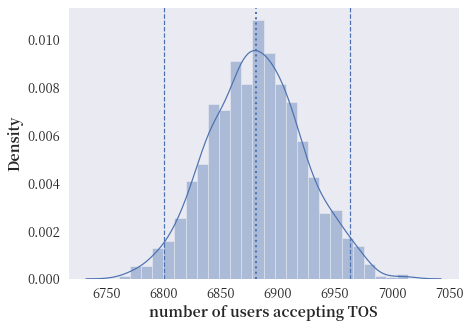

In [19]:
plot_distribution(num_users_accepted_TOS, 'num_users_accepting_TOS')

In [20]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_accepted_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 6800.95000
97.5% percentile: 6963.00000

mean value: 6881.18000


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


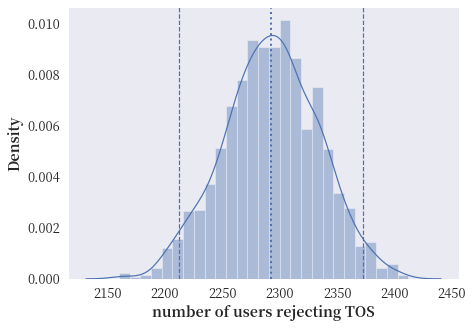

In [21]:
plot_distribution(num_users_rejected_TOS, 'num_users_rejecting_TOS')

In [22]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_rejected_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2212.00000
97.5% percentile: 2373.00000

mean value: 2292.73867


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


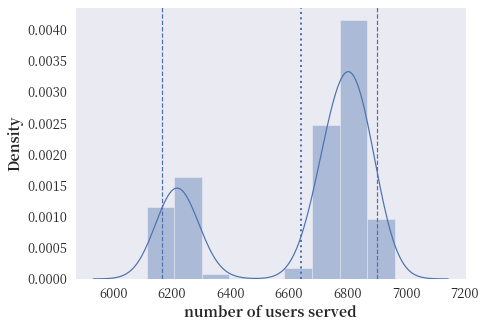

In [23]:
plot_distribution(num_users_served, 'num_users_served')

In [24]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 6165.47500
97.5% percentile: 6900.52500

mean value: 6641.10200


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


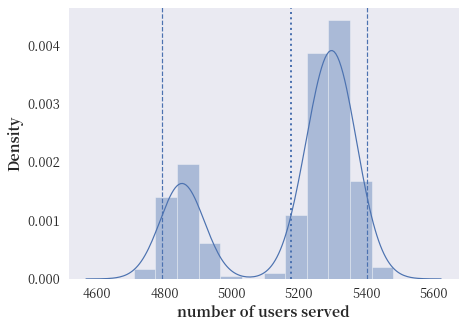

In [25]:
plot_distribution(num_users_served_g_regular, 'num_users_served_g_regular')

In [26]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4792.47500
97.5% percentile: 5401.52500

mean value: 5176.05533


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


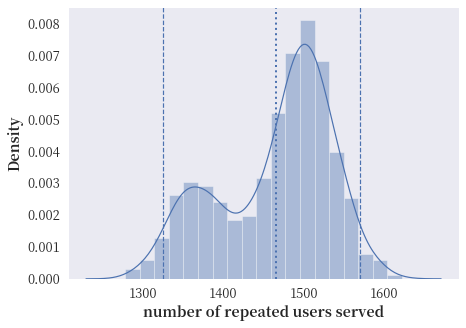

In [27]:
plot_distribution(num_users_served_g_repeated, 'num_users_served_g_repeated')

In [28]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 1325.00000
97.5% percentile: 1570.05000

mean value: 1465.04667


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


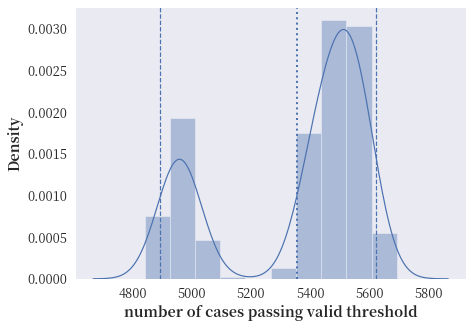

In [29]:
plot_distribution(num_users_served_g_valid, 'num_users_served_g_repeated')

In [30]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_valid.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4893.00000
97.5% percentile: 5622.00000

mean value: 5354.38533


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


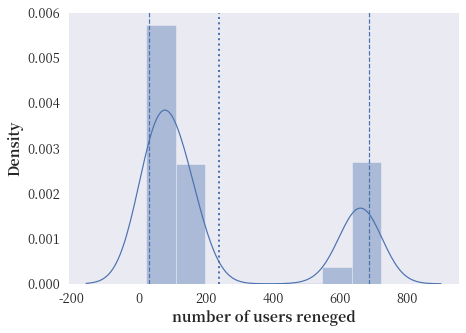

In [31]:
plot_distribution(num_users_reneged, 'num_users_reneged')

In [32]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 30.00000
97.5% percentile: 687.00000

mean value: 240.07800


In [33]:
# plot_distribution(num_users_reneged_g_regular, 'num_users_reneged_g_regular')

In [34]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_regular.sort_values().to_list() )

In [35]:
# plot_distribution(num_users_reneged_g_repeated, 'num_users_reneged_g_repeated')

In [36]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_repeated.sort_values().to_list() )

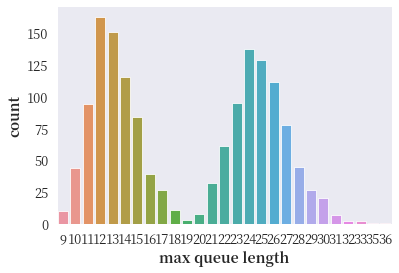

In [37]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'{folder}/max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [38]:
queue_status['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [39]:
queue_status

,weekday,hour,queue_length
0,Sunday,0,0
1,Sunday,0,0
2,Sunday,0,0
3,Sunday,0,0
4,Sunday,0,0
...,...,...,...
7913,Monday,23,0
7914,Monday,23,0
7915,Monday,23,0
7916,Monday,23,0


In [40]:
queue_status['total']=1

# chat time

In [41]:
case_chat_time.describe().T

,count,mean,std,min,25%,50%,75%,max
cumulative_chat_time,9945305.0,55.094623,43.089187,0.000002,24.487398,44.924228,74.220531,660.0


In [42]:
# case_chat_time[case_chat_time['cumulative_chat_time']>0].describe().T

<AxesSubplot:xlabel='cumulative_chat_time', ylabel='Count'>

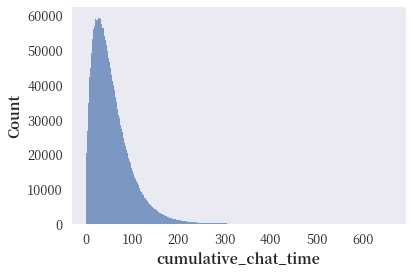

In [43]:
sns.histplot(case_chat_time['cumulative_chat_time'])

<AxesSubplot:xlabel='cumulative_chat_time', ylabel='Density'>

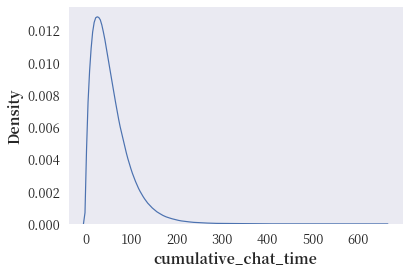

In [44]:
sns.kdeplot(case_chat_time['cumulative_chat_time'])

# queue length

In [45]:
totals = queue_status.groupby(
    ['weekday', 'hour', 'queue_length']).sum()

In [46]:
totals = totals.reset_index()

In [47]:
totals

,weekday,hour,queue_length,total
0,Friday,0,0,82383
1,Friday,0,1,8177
2,Friday,0,2,7225
3,Friday,0,3,6002
4,Friday,0,4,4832
...,...,...,...,...
1957,Wednesday,22,13,3
1958,Wednesday,22,14,1
1959,Wednesday,23,0,106809
1960,Wednesday,23,1,4


In [48]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['hour'], aggfunc=np.sum, fill_value=0)

In [49]:
totals_percent = totals.div(totals.sum(axis=1), axis=0)#.round(2)

In [50]:
totals_percent

queue_length,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
hour,,,,,,,,,,,,,,,,,,,,,
0,0.704699,0.065952,0.058995,0.050416,0.040682,0.030660,0.021246,0.013495,0.007530,0.003660,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.643888,0.006798,0.004661,0.003812,0.004009,0.004890,0.006599,0.009035,0.012544,0.016693,...,0.000550,0.000317,0.000183,0.000098,0.000048,0.000016,0.000010,0.000004,0.000004,0.000002
2,0.468210,0.020673,0.020841,0.021686,0.023551,0.026591,0.030314,0.033525,0.035962,0.037775,...,0.000098,0.000063,0.000026,0.000010,0.000012,0.000008,0.000004,0.000000,0.000000,0.000000
3,0.654850,0.001272,0.003878,0.008684,0.015410,0.021901,0.026959,0.029933,0.032308,0.033902,...,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.451211,0.015219,0.033605,0.053197,0.065472,0.070388,0.067047,0.062267,0.053577,0.042344,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.537938,0.097915,0.090672,0.078815,0.063098,0.047382,0.032995,0.021582,0.013170,0.007929,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.799103,0.109337,0.052870,0.023023,0.009722,0.003898,0.001389,0.000469,0.000154,0.000027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.972232,0.014733,0.007688,0.003520,0.001304,0.000397,0.000101,0.000016,0.000004,0.000004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
totals_percent['>=2'] = totals_percent[totals_percent.columns[totals_percent.columns >= 2]].sum(axis=1)

In [52]:
totals_percent3 = totals_percent[[0, 1, '>=2']].copy()

In [53]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR, 
    MAX_SIMULTANEOUS_CHATS,
    NUM_DUTY_OFFICERS,
    NUM_SOCIAL_WORKERS,
    NUM_VOLUNTEERS
)

In [54]:
NUM_DUTY_OFFICERS

{'GRAVEYARD': 1, 'AM': 1, 'PM': 1, 'SPECIAL': 0}

In [55]:
MAX_SIMULTANEOUS_CHATS

{'SOCIAL_WORKER': 3, 'DUTY_OFFICER': 1, 'VOLUNTEER': 2}

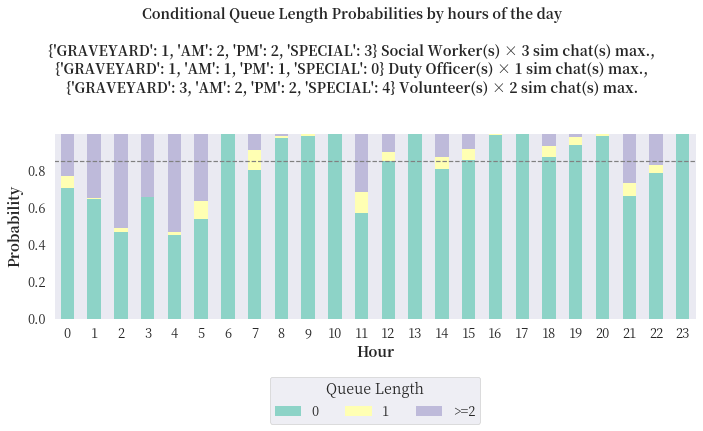

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Conditional Queue Length Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)


    
totals_percent3.plot.bar(
        stacked=True,
        ax=ax,
        linewidth=.01,
        color=palette,
        rot=0
    )

ax.axhline(y=.85, linestyle='--', color='grey')
#     ax[i].set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
#         if x[-2:] == '_0' else ''
#         for x in dataframe.index])

ax.set_xlabel('Hour')
ax.set_ylabel('Probability')
    
ax.legend(loc='lower center', 
    bbox_to_anchor=(0.5, -.6), 
    ncol=3,
    title='Queue Length'     
)
    
fig.tight_layout()

fig.savefig(f'{folder}/queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# queue time

In [57]:
# queue_plot = sns.catplot(col='weekday', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [58]:
queue_time_stats

,weekday,hour,time_spent_in_queue
0,0,0,0.0
1,0,0,0.0
2,0,0,0.0
3,0,0,0.0
4,0,0,0.0
...,...,...,...
7731,1,23,0.0
7732,1,23,0.0
7733,1,23,0.0
7734,1,23,0.0


In [59]:
queue_time_stats['total']=1

In [60]:
# # totals = 
# queue_time_stats.mean()

In [61]:
queue_time_stats['queue_time_group'] = queue_time_stats['time_spent_in_queue'].apply(
    lambda x: 'direct' if x==0 else (
        '<5 minutes' if x < 5 and x>0 else (
        '5-10 minutes' if x >=5 and x<10 else '>=10 minutes'
        ) )
)

In [62]:
queue_time_stats['queue_time_group']

0       direct
1       direct
2       direct
3       direct
4       direct
         ...  
7731    direct
7732    direct
7733    direct
7734    direct
7735    direct
Name: queue_time_group, Length: 11324478, dtype: object

In [63]:
queue_time_stats = pd.pivot_table(queue_time_stats, values='total', columns=['queue_time_group'],
              index=['hour'], aggfunc=np.sum, fill_value=0)

In [64]:
queue_time_stats

queue_time_group,5-10 minutes,<5 minutes,>=10 minutes,direct
hour,,,,
0,25102,35045,28982,699443
1,3572,5568,4604,319321
2,7136,6926,112997,227092
3,29,73,793,186869
4,10,2,703,82586
5,5159,5621,94515,101435
6,0,0,0,147912
7,13392,17861,15342,242131
8,2918,3959,4627,234087


In [65]:
queue_time_stats_percent = (queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0))#.round(2)

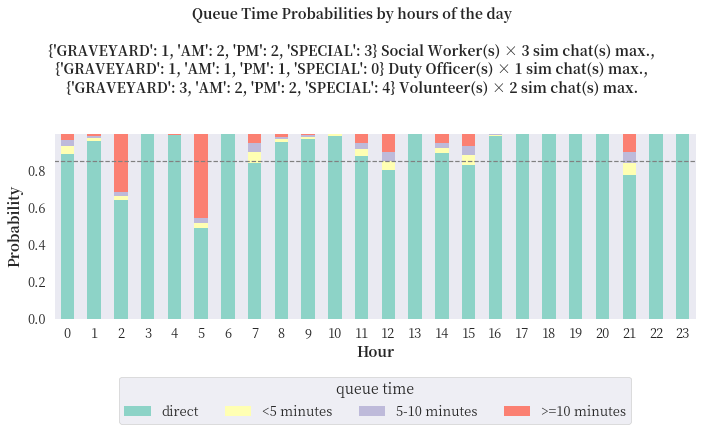

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Queue Time Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)


queue_time_stats_percent[['direct', '<5 minutes', '5-10 minutes', '>=10 minutes']].plot.bar(
        stacked=True,
        ax=ax,
        linewidth=.01,
        color=palette,
        rot=0
    )

ax.axhline(y=.85, linestyle='--', color='grey')

ax.set_xlabel('Hour')
ax.set_ylabel('Probability')
    
ax.legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.6), 
                     ncol=4,
                     title='queue time'
            )
    
fig.tight_layout()

fig.savefig(f'{folder}/queue_time_prob_plot.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [67]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR)

In [68]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle
0,16.523050,33
1,17.272167,32
2,17.721433,31
3,19.524283,30
4,26.033167,29
...,...,...
7913,43173.494917,37
7914,43181.024100,36
7915,43181.674933,35
7916,43187.151350,35


In [69]:
num_available_counsellor_processes['time_int'] = num_available_counsellor_processes['time'].astype(int)

In [70]:
num_available_counsellor_processes['current_day_minutes'] = num_available_counsellor_processes['time_int'] % MINUTES_PER_DAY

In [71]:
num_available_counsellor_processes['hour'] = (num_available_counsellor_processes['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [72]:
num_available_counsellor_processes['total']=1

In [73]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle,time_int,current_day_minutes,hour,total
0,16.523050,33,16,16,0,1
1,17.272167,32,17,17,0,1
2,17.721433,31,17,17,0,1
3,19.524283,30,19,19,0,1
4,26.033167,29,26,26,0,1
...,...,...,...,...,...,...
7913,43173.494917,37,43173,1413,23,1
7914,43181.024100,36,43181,1421,23,1
7915,43181.674933,35,43181,1421,23,1
7916,43187.151350,35,43187,1427,23,1


In [74]:
df2 = pd.pivot_table(
    num_available_counsellor_processes, values='total',
    columns=['num_counsellor_processes_idle'],
    index=['hour'], aggfunc=np.sum, fill_value=0)

In [75]:
df2 = (((df2.T/df2.T.sum()).T)*100)#.round(2)

In [76]:
# df2 = df2.reset_index(drop=False).drop(columns=['weekday'])
# selection = df2[df2['day_of_week']=='Monday'].copy()

In [77]:
# df2.groupby('hour').mean()

In [78]:
# selection.set_index(['day_of_week', 'hour']).to_excel(
#     'queue_output/num_idle_procs_SW_2434_DO_11_V_2423-45.xlsx')

In [79]:
queue_time_stats

queue_time_group,5-10 minutes,<5 minutes,>=10 minutes,direct
hour,,,,
0,25102,35045,28982,699443
1,3572,5568,4604,319321
2,7136,6926,112997,227092
3,29,73,793,186869
4,10,2,703,82586
5,5159,5621,94515,101435
6,0,0,0,147912
7,13392,17861,15342,242131
8,2918,3959,4627,234087


In [80]:
renege_time_stats

,weekday,hour,time_spent_in_queue
0,0,14,1.074768
1,0,14,17.252101
2,0,14,8.337575
3,0,14,23.232323
4,1,1,18.932622
...,...,...,...
177,1,4,23.229564
178,1,4,23.618383
179,1,4,33.961203
180,1,4,43.149112


In [81]:
renege_time_stats['time_spent_in_queue'].describe()

count    625137.000000
mean         42.910544
std          40.306410
min           0.000090
25%          13.413795
50%          31.258591
75%          57.554324
max         247.319186
Name: time_spent_in_queue, dtype: float64

<AxesSubplot:xlabel='time_spent_in_queue', ylabel='Density'>

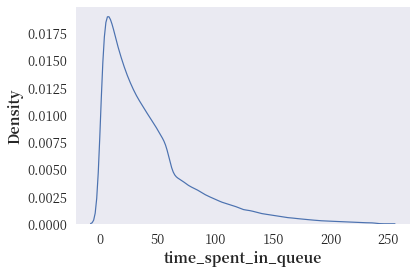

In [82]:
sns.kdeplot(renege_time_stats['time_spent_in_queue'])

<AxesSubplot:xlabel='hour', ylabel='Count'>

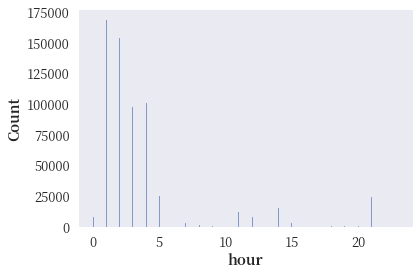

In [83]:
sns.histplot(renege_time_stats['hour'])

In [84]:
df2

num_counsellor_processes_idle,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.849559,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,34.642475,3.163072,1.409088,1.777110,2.256176,2.748001,3.127386,3.424634,3.671245,3.659084,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12.969252,18.312071,22.445707,2.575963,0.679845,0.918017,1.211349,1.522017,1.824214,2.084844,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.754203,33.466916,0.454343,0.145726,0.273937,0.446286,0.693250,1.057565,1.493342,2.010390,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.048292,53.852881,0.398134,0.008147,0.011949,0.020097,0.028244,0.057031,0.099941,0.161317,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.162731,11.105883,35.012302,9.895541,0.054388,0.000000,0.000432,0.001295,0.003453,0.007338,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001352,0.008113,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.033536,2.290701,1.851998,2.582599,3.441526,4.531440,5.986483,7.129780,7.748139,7.320729,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.129220,6.835315,4.343670,5.545136,6.979118,8.287931,9.395824,9.936200,9.616592,8.110101,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [85]:
df2['>10'] = df2[df2.columns[df2.columns > 10]].T.sum()

In [86]:
df2 = df2[[x for x in range(11)] + ['>10']].copy()

In [87]:
df2 = df2.T

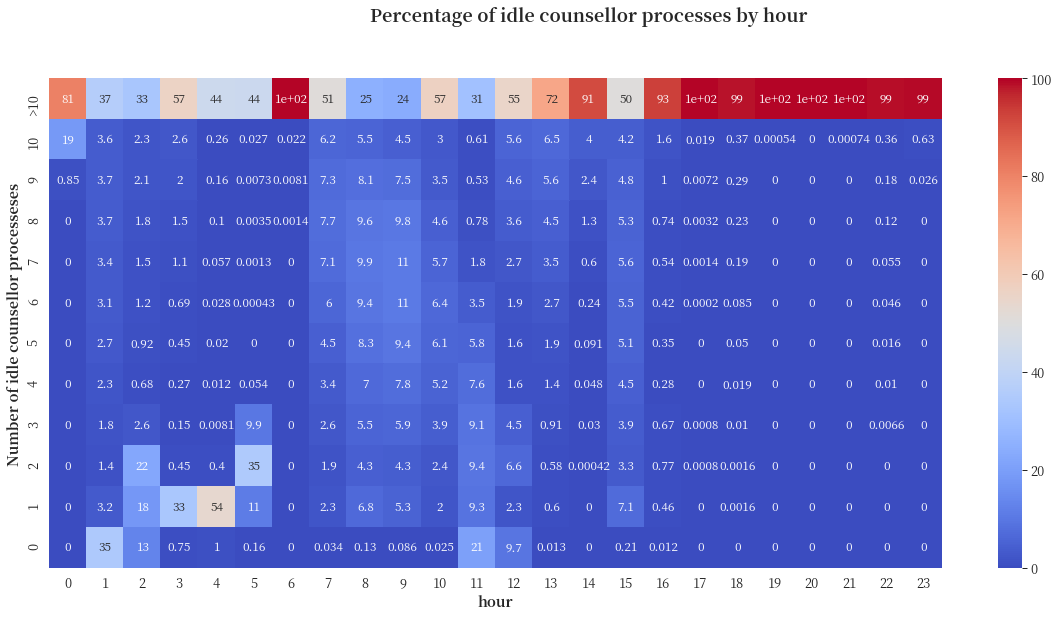

In [88]:
fig, ax = plt.subplots(figsize=(20, 10) )


sns.heatmap(df2[::-1], annot=True, ax=ax, annot_kws={"size": 12}, 
    cmap="coolwarm",
);
fig.suptitle('Percentage of idle counsellor processes by hour',
    fontsize=18, weight='heavy',
    fontweight=1000)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel('Number of idle counsellor processeses')

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
df2

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
num_counsellor_processes_idle,,,,,,,,,,,,,,,,,,,,,
0,0.000000,34.642475,12.969252,0.754203,1.048292,0.162731,0.000000,0.033536,0.129220,0.085874,...,0.000000,0.208559,0.012496,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
1,0.000000,3.163072,18.312071,33.466916,53.852881,11.105883,0.000000,2.290701,6.835315,5.270242,...,0.000000,7.086422,0.459087,0.000000,0.001626,0.00000,0.0,0.000000,0.000000,0.000000
2,0.000000,1.409088,22.445707,0.454343,0.398134,35.012302,0.000000,1.851998,4.343670,4.251741,...,0.000418,3.275846,0.769447,0.000796,0.001626,0.00000,0.0,0.000000,0.000000,0.000000
3,0.000000,1.777110,2.575963,0.145726,0.008147,9.895541,0.000000,2.582599,5.545136,5.910100,...,0.030483,3.868853,0.670295,0.000796,0.010241,0.00000,0.0,0.000000,0.006627,0.000000
4,0.000000,2.256176,0.679845,0.273937,0.011949,0.054388,0.000000,3.441526,6.979118,7.755384,...,0.047813,4.534618,0.279836,0.000000,0.018694,0.00000,0.0,0.000000,0.010493,0.000000
5,0.000000,2.748001,0.918017,0.446286,0.020097,0.000000,0.000000,4.531440,8.287931,9.395769,...,0.091449,5.098311,0.347234,0.000000,0.049905,0.00000,0.0,0.000000,0.016475,0.000000
6,0.000000,3.127386,1.211349,0.693250,0.028244,0.000432,0.000000,5.986483,9.395824,10.548073,...,0.239063,5.454327,0.421598,0.000199,0.084854,0.00000,0.0,0.000000,0.046481,0.000000
7,0.000000,3.424634,1.522017,1.057565,0.057031,0.001295,0.000000,7.129780,9.936200,10.920325,...,0.597136,5.603727,0.536523,0.001393,0.185313,0.00000,0.0,0.000000,0.054764,0.000000
8,0.000000,3.671245,1.824214,1.493342,0.099941,0.003453,0.001352,7.748139,9.616592,9.841114,...,1.328314,5.309872,0.735850,0.003184,0.233755,0.00000,0.0,0.000000,0.117720,0.000000
